## Load libraries

In [3]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
import pandas as pd
import ast                      # convert string to list after importing csv data
import pickle

# Libraries to cluster data
from hdbscan import HDBSCAN

# Libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
# import matplotlib.cm as cm
from cluster_visualization_helper import (
    visualize_cluster)  # user-defined functions

# Libraries for evaluation
from sklearn import metrics

# Libraries for monitoring operation process
from datetime import datetime
from tqdm import tqdm
from joblib import Memory

In [9]:
# !pip install hdbscan
# !pip install MulticoreTSNE
# !pip install umap-learn

## Configurate and declare global variables

In [4]:
try:
    username = os.environ['HOSTNAME']
except:
    username = os.environ['COMPUTERNAME']

n_cpu = os.cpu_count()

os_name = os.name
username, n_cpu, os_name

('PINKA-ASUS-VIVO', 8, 'nt')

In [5]:
if os_name == 'nt':
    """Windows platform"""
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"

elif os_name == 'posix':
    """Linux platform"""
    if username == 'PinkaLinux':
        BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    else:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        BASE_DIR = "/content/drive/MyDrive/MASTER TILBURG/THESIS/"

INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
RESULT_DIR = BASE_DIR + "RESULTS/"

SEED = 6886
%matplotlib inline

## Import data

In [6]:
skill_embeddings = np.load(OUTPUT_DIR + "skill_feat_halfsize_embeddings.npy")
skill_embeddings.shape

(257205, 150)

In [7]:
skill_docs = pd.read_csv(
    OUTPUT_DIR + "skill_tokens_long_df.csv",
    converters={
        "skill_token": ast.literal_eval,
    },
    dtype={
        "key_id": int,
        "skill_id": int,
        "job_id": int,
        "column_type": str,
        "skill": str,
        "skill_lemma": str
    }
)
skill_docs.shape

(257205, 9)

In [8]:
skill_docs

,row_id,key_id,job_id,skill_id,column_id,column_type,skill,skill_lemma,skill_token
0,10101,101,1,1,1,job_description,ameria investment consulting company,ameria investment consult company,"[ameria, investment, consult, company]"
1,10201,102,1,2,1,job_description,requires high level,require high level,"[require, high, level]"
2,10301,103,1,3,1,job_description,provides highly responsible,provide highly responsible,"[provide, highly, responsible]"
3,10401,104,1,4,1,job_description,complex staff assistance,complex staff assistance,"[complex, staff, assistance]"
4,10501,105,1,5,1,job_description,chief financial officer,chief financial officer,"[chief, financial, officer]"
...,...,...,...,...,...,...,...,...,...
257200,190010103,1900101,19001,1,3,job_qualification,ra financial system,ra financial system,"[ra, financial, system]"
257201,190010203,1900102,19001,2,3,job_qualification,higher legal education,high legal education,"[high, legal, education]"
257202,190010303,1900103,19001,3,3,job_qualification,high pressure environment,high pressure environment,"[high, pressure, environment]"
257203,190010403,1900104,19001,4,3,job_qualification,professional work experience,professional work experience,"[professional, work, experience]"


## Clustering data

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=SEED).fit(skill_embeddings)
X = pca.transform(skill_embeddings)
X.shape

(257205, 2)

### HDBSCAN

In [8]:
def hdbscan_clusterer(X, min_samples, min_cluster_size, memory):
    """Generate clusters using HDBSCAN method
    Hierarchical Density-Based Spatial Clustering of Applications with Noise

    Args:
        X:                 Matrix of features
                             (n_samples, n_features)
        min_samples:       The number of samples in a neighborhood for a point
                             to be considered as a core point
                             (int, default=None)
        min_cluster_size:  The minimum size of clusters
                             (int, default=5)

    Returns:
        Trained clustering model based on X
    """
    clusterer = HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size,
        # algorithm='boruvka_kdtree',
        # gen_min_span_tree=True,
        core_dist_n_jobs=n_cpu,
        # memory=memory,
    )
    clusterer.fit(X)
    return clusterer

In [15]:
# Define search space for tuning hyperparameters
# X = skill_embeddings
mem = Memory(location=OUTPUT_DIR + "/cachedir")
tuning_result = {
    "n_clusters": [],
    "n_noises": [],
    "min_samples": [],
    "min_cluster_size": [],
    "duration": [],
}
model_list = []
label_list = []
# outlier_list = []
# exemplar_list = []
min_samples_list = [3, 5, 10, 25, 50]
# min_samples_list = [5, 10]
min_cluster_size_list = [3, 5, 10, 25, 50]
len(min_samples_list) * len(min_cluster_size_list)

25

In [16]:
# Tuning hyperparameter
start_loop_time = datetime.now()
print("Start loop", start_loop_time.strftime("%Y-%m-%d %H:%M:%S.%f"))

for min_samples in tqdm(
    iterable=min_samples_list,
    desc="Tuning HDBSCAN Clustering",
    total=len(min_samples_list),
):
    for min_cluster_size in min_cluster_size_list:

        # Train model
        starttime = datetime.now()
        print("Start", starttime.strftime("%Y-%m-%d %H:%M:%S.%f"))
        print("min_samples =", min_samples)
        print("min_cluster_size =", min_cluster_size)

        clusterer = hdbscan_clusterer(X, min_samples, min_cluster_size, mem)

        endtime = datetime.now()
        print("End", endtime.strftime("%Y-%m-%d %H:%M:%S.%f"))
        print("Duration", endtime - starttime)

        # Save model
        pickle.dump(
            clusterer,
            open(
                OUTPUT_DIR
                + "hdbscan/"
                + "skill_hdbscan_model_min_samples-"
                + str(min_samples)
                + "_min_cluster_size-"
                + str(min_cluster_size)
                + ".pkl",
                "wb",
            ),
        )

        model_list.append(clusterer)
        labels = clusterer.labels_
        label_list.append(labels)
        # outlier_list.append(clusterer.outlier_scores_)
        # exemplar_list.append(clusterer.exemplars_)
        tuning_result["duration"].append(round((endtime - starttime).seconds / 60, 4))
        tuning_result["min_samples"].append(min_samples)
        tuning_result["min_cluster_size"].append(min_cluster_size)
        tuning_result["n_noises"].append(np.sum(np.array(labels) == -1, axis=0))
        tuning_result["n_clusters"].append(np.sum(np.unique(labels) != -1, axis=0))

#         tqdm_bar.update(1)

# tqdm_bar.close()
end_loop_time = datetime.now()
print("End loop", end_loop_time.strftime("%Y-%m-%d %H:%M:%S.%f"))
print("Duration", end_loop_time - start_loop_time)

Tuning HDBSCAN Clustering:   0%|          | 0/5 [00:00<?, ?it/s]Start loop 2021-05-20 23:06:30.802013
Start 2021-05-20 23:06:30.805016
min_samples = 3
min_cluster_size = 3
End 2021-05-20 23:07:19.304609
Duration 0:00:48.499593
Start 2021-05-20 23:07:19.396610
min_samples = 3
min_cluster_size = 5
End 2021-05-20 23:08:01.755310
Duration 0:00:42.358700
Start 2021-05-20 23:08:01.859310
min_samples = 3
min_cluster_size = 10
End 2021-05-20 23:08:29.904924
Duration 0:00:28.045614
Start 2021-05-20 23:08:29.968927
min_samples = 3
min_cluster_size = 25
End 2021-05-20 23:08:50.822944
Duration 0:00:20.854017
Start 2021-05-20 23:08:50.886939
min_samples = 3
min_cluster_size = 50
Tuning HDBSCAN Clustering:  20%|██        | 1/5 [02:39<10:36, 159.08s/it]End 2021-05-20 23:09:09.814211
Duration 0:00:18.927272
Start 2021-05-20 23:09:09.888211
min_samples = 5
min_cluster_size = 3
End 2021-05-20 23:09:48.855793
Duration 0:00:38.967582
Start 2021-05-20 23:09:49.016791
min_samples = 5
min_cluster_size = 5
En

In [17]:
tuning_result["silhouette"] = []
tuning_result["silhouette_error"] = []

tqdm_bar = tqdm(desc="Computing Silhouette score", total=len(model_list))
for i, _ in enumerate(model_list):
    try:
        silhouette = metrics.silhouette_score(
            X, label_list[i], sample_size=10000, random_state=SEED, n_jobs=-1
        )
        tuning_result["silhouette_error"].append("None")
    except Exception as e:
        print(e)
        silhouette = -1.1
        tuning_result["silhouette_error"].append(e)
    tuning_result["silhouette"].append(silhouette)
    tqdm_bar.update(1)
tqdm_bar.close()

Computing Silhouette score: 100%|██████████| 25/25 [02:25<00:00,  5.84s/it]


In [18]:
tuning_result["calinski_harabasz"] = []
tuning_result["calinski_harabasz_error"] = []

tqdm_bar = tqdm(desc="Computing Calinski Harabasz score", total=len(model_list))
for i, _ in enumerate(model_list):
    try:
        calinski_harabasz = metrics.calinski_harabasz_score(X, label_list[i])
        tuning_result["calinski_harabasz_error"].append("None")
    except Exception as e:
        print(e)
        calinski_harabasz = -1.1
        tuning_result["calinski_harabasz_error"].append(e)
    tuning_result["calinski_harabasz"].append(calinski_harabasz)
    tqdm_bar.update(1)
tqdm_bar.close()

Computing Calinski Harabasz score: 100%|██████████| 25/25 [04:40<00:00, 11.22s/it]


In [19]:
tuning_result["davies_bouldin"] = []
tuning_result["davies_bouldin_error"] = []

tqdm_bar = tqdm(desc="Computing Davies Bouldin score", total=len(model_list))
for i, _ in enumerate(model_list):
    try:
        davies_bouldin = metrics.davies_bouldin_score(X, label_list[i])
        tuning_result["davies_bouldin_error"].append("None")
    except Exception as e:
        print(e)
        davies_bouldin = -1.1
        tuning_result["davies_bouldin_error"].append(e)
    tuning_result["davies_bouldin"].append(davies_bouldin)
    tqdm_bar.update(1)
tqdm_bar.close()

Computing Davies Bouldin score: 100%|██████████| 25/25 [09:34<00:00, 22.98s/it]


In [20]:
tuning_result["silhouette_corr"] = []
tuning_result["silhouette_corr_error"] = []

tqdm_bar = tqdm(desc="Computing Silhouette (correlation) score", total=len(model_list))
for i, _ in enumerate(model_list):
    try:
        silhouette = metrics.silhouette_score(
            X,
            label_list[i],
            sample_size=10000,
            random_state=SEED,
            n_jobs=-1,
            metric="correlation",
        )
        tuning_result["silhouette_corr_error"].append("None")
    except Exception as e:
        print(e)
        silhouette = -1.1
        tuning_result["silhouette_corr_error"].append(e)
    tuning_result["silhouette_corr"].append(silhouette)
    tqdm_bar.update(1)
tqdm_bar.close()

Computing Silhouette (correlation) score:  16%|█▌        | 4/25 [00:08<00:28,  1.35s/it]Unable to allocate 95.4 MiB for an array with shape (10000, 1250) and data type float64
Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64
Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64
Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64
Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64
Computing Silhouette (correlation) score:  40%|████      | 10/25 [00:08<00:05,  2.86it/s]Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64
Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64
Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64
Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64
Unable to allocate 763.

In [21]:
# Display tuning results
tuning_result_df = pd.DataFrame(tuning_result)
tuning_result_df

,n_clusters,n_noises,min_samples,min_cluster_size,duration,silhouette,silhouette_error,calinski_harabasz,calinski_harabasz_error,davies_bouldin,davies_bouldin_error,silhouette_corr,silhouette_corr_error
0,19130,26320,3,3,0.8000,0.370185,None,297.635274,None,-1.100000,Unable to allocate 2.73 GiB for an array with ...,-0.2212,None
1,14661,27809,3,5,0.7000,0.372690,None,355.107991,None,-1.100000,Unable to allocate 1.60 GiB for an array with ...,-1.1000,Unable to allocate 95.4 MiB for an array with ...
2,7736,32713,3,10,0.4667,0.372731,None,535.486040,None,1.764061,None,-1.1000,Unable to allocate 763. MiB for an array with ...
3,3162,42421,3,25,0.3333,0.320440,None,851.331945,None,1.869155,None,-1.1000,Unable to allocate 763. MiB for an array with ...
4,1596,53722,3,50,0.3000,0.219159,None,1132.078756,None,2.197136,None,-1.1000,Unable to allocate 763. MiB for an array with ...
5,14198,39728,5,3,0.6333,0.321359,None,267.177398,None,-1.100000,Unable to allocate 1.50 GiB for an array with ...,-1.1000,Unable to allocate 763. MiB for an array with ...
6,11643,40482,5,5,0.5500,0.326773,None,320.832683,None,-1.100000,Unable to allocate 1.01 GiB for an array with ...,-1.1000,Unable to allocate 763. MiB for an array with ...
7,7111,43095,5,10,0.4500,0.334603,None,464.145212,None,1.726653,None,-1.1000,Unable to allocate 763. MiB for an array with ...
8,2995,49271,5,25,0.3667,0.298786,None,812.461243,None,1.868838,None,-1.1000,Unable to allocate 763. MiB for an array with ...
9,1543,59161,5,50,0.3333,0.202597,None,1104.889242,None,1.892232,None,-1.1000,Unable to allocate 763. MiB for an array with ...


In [22]:
# Save tuning results
tuning_result_df.to_csv(
    RESULT_DIR + "hdbscan/" + "skill_hdbscan_tuning_result.csv", index=False
)

In [23]:
# Combine model sets
tuple_objects = (
    model_list,
    label_list,
    outlier_list,
    exemplar_list,
    tuning_result,
)
len(tuple_objects), len(tuple_objects[0])

(5, 25)

In [24]:
# Save tuple of model sets
pickle.dump(
    tuple_objects, open(RESULT_DIR + "hdbscan/" + "skill_hdbscan_model_tuning_list.pkl", "wb")
)

## Evaluate cluster performance

In [26]:
# # Calculate other validation indices
# model_validation = {
#     "min_samples": tuning_result["min_samples"],
#     "min_cluster_size": tuning_result["min_cluster_size"],
#     "n_clusters": tuning_result["n_clusters"],
#     "relative_validity": [],
#     "cluster_persistence": [],
# }

# for i in tqdm(range(len(model_list))):
#     model = model_list[i]

#     # Retrieve relative validity
#     """
#     float
#     A fast approximation of the Density Based Cluster Validity (DBCV) score. 
#     The only difference, and the speed, comes from the fact that 
#     this relative_validity_ is computed using 
#     the mutual- reachability minimum spanning tree, i.e. minimum_spanning_tree_, 
#     instead of the all-points minimum spanning tree used in the reference. 
#     This score might not be an objective measure of 
#     the goodness of clusterering. 
#     It may only be used to compare results across 
#     different choices of hyper-parameters, therefore is only a relative score.
#     """
#     relative_validity = model.relative_validity_

#     # Retrieve cluster persistence
#     """
#     ndarray, shape (n_clusters, )
#     A score of how persistent each cluster is. 
#     A score of 1.0 represents a perfectly stable cluster 
#     that persists over all distance scales, 
#     while a score of 0.0 represents a perfectly ephemeral cluster. 
#     These scores can be gauge the relative coherence 
#     of the clusters output by the algorithm.
#     """
#     cluster_persistence = model.cluster_persistence_

#     model_validation["relative_validity"].append(relative_validity)
#     model_validation["cluster_persistence"].append(cluster_persistence)

In [ ]:
# model_validation_df = pd.DataFrame(
#     {
#         "min_samples": model_validation["min_samples"],
#         "min_cluster_size": model_validation["min_cluster_size"],
#         "n_clusters": model_validation["n_clusters"],
#         "relative_validity": model_validation["relative_validity"],
#     }
# )

In [ ]:
# # Save validation results
# model_validation_df.to_csv(
#     RESULT_DIR + "hdbscan/" + "skill_hdbscan_validation_result.csv", index=False
# )

In [27]:
# Combine model sets
tuple_objects2 = (
    model_list,
    label_list,
    # outlier_list,
    # exemplar_list,
    tuning_result,
    # model_validation,
)
len(tuple_objects2), len(tuple_objects2[0])

(3, 25)

In [28]:
# Save tuple
pickle.dump(
    tuple_objects2,
    open(OUTPUT_DIR + "hdbscan/" + "skill_hdbscan_tuning_validation_list.pkl", "wb"),
)

#### Number of clusters found

In [29]:
# List of markers for subplots
marker_dict = {
    ".": "point",
    ",": "pixel",
    "o": "circle",
    "v": "triangle_down",
    "^": "triangle_up",
    "<": "triangle_left",
    ">": "triangle_right",
    "1": "tri_down",
    "2": "tri_up",
    "3": "tri_left",
    "4": "tri_right",
    "8": "octagon",
    "s": "square",
    "p": "pentagon",
    "*": "star",
    "h": "hexagon1",
    "H": "hexagon2",
    "+": "plus",
    "x": "x",
    "D": "diamond",
    "d": "thin_diamond",
    "|": "vline",
    "_": "hline",
    "P": "plus_filled",
    "X": "x_filled",
    0: "tickleft",
    1: "tickright",
    2: "tickup",
    3: "tickdown",
    4: "caretleft",
    5: "caretright",
    6: "caretup",
    7: "caretdown",
    8: "caretleftbase",
    9: "caretrightbase",
    10: "caretupbase",
    11: "caretdownbase",
}
marker_list = list(marker_dict.keys())

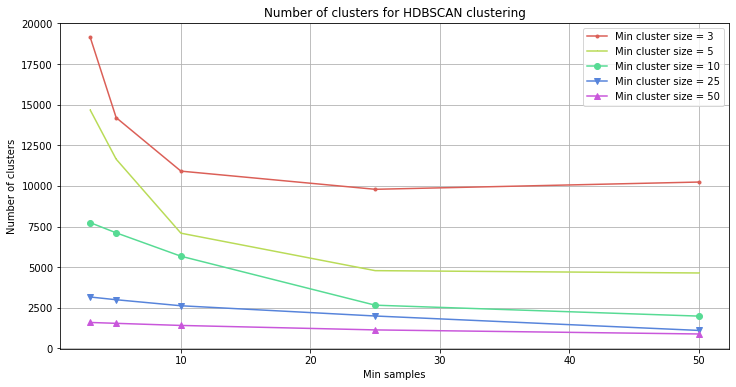

In [30]:
palette = sns.color_palette("hls", n_colors=len(min_cluster_size_list))

# The higher the better
fig = plt.figure(figsize=(12, 6))
for idx, min_cluster_size in enumerate(min_cluster_size_list):
    plt.plot(
        tuning_result_df["min_samples"].loc[
            tuning_result_df["min_cluster_size"] == min_cluster_size
        ],        
        tuning_result_df["n_clusters"].loc[
            tuning_result_df["min_cluster_size"] == min_cluster_size
        ],        
        label="Min cluster size = "
        + str(min_cluster_size),
        color=palette[idx],
        marker=marker_list[idx]
    )
plt.ylabel("Number of clusters")
# plt.yticks(np.unique(model_result_df["number_clusters"]))
plt.xlabel("Min samples")
# plt.xticks(np.unique(model_result_df["min_samples"]))
plt.title("Number of clusters for HDBSCAN clustering")
plt.legend(loc="best")
plt.grid()

# Saving plot as image
fig.savefig(
    RESULT_DIR + "hdbscan/" + "skill_hdbscan_n_clusters_plot.png",
#     bbox_inches="tight",
#     dpi=150,
)

# Show plot
plt.show()

#### Silhoulette score

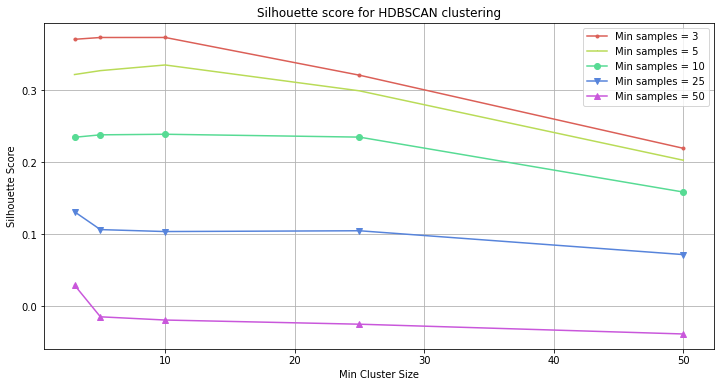

In [31]:
palette = sns.color_palette("hls", n_colors=len(min_samples_list))

# The higher the better
fig, ax1 = plt.subplots(figsize=(12, 6))
for idx, min_samples in enumerate(min_samples_list):
    ax1.plot(
        tuning_result_df["min_cluster_size"].loc[
            tuning_result_df["min_samples"] == min_samples
        ],
        tuning_result_df["silhouette"].loc[
            tuning_result_df["min_samples"] == min_samples
        ],
        label="Min samples = "
        + str(min_samples), color=palette[idx],
        marker=marker_list[idx]
    )
ax1.set_xlabel("Min Cluster Size")
# ax1.set_xticks(min_cluster_size_list)
ax1.set_ylabel("Silhouette Score")
ax1.set_title("Silhouette score for HDBSCAN clustering")
ax1.legend(loc="best")
ax1.grid()

# Saving plot as image
fig.savefig(
    RESULT_DIR + "hdbscan/" + "skill_hdbscan_silhouette_plot.png",
#     bbox_inches="tight",
#     dpi=150,
)

# Show plot
plt.show()

#### Calinski Harabasz Score

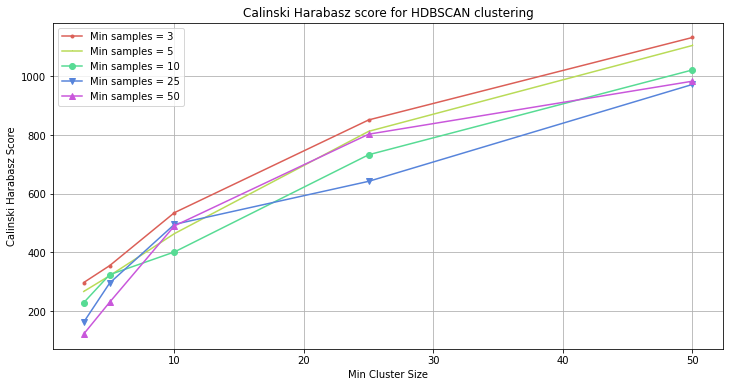

In [32]:
palette = sns.color_palette("hls", n_colors=len(min_samples_list))

# The higher the better
fig, ax1 = plt.subplots(figsize=(12, 6))
for idx, min_samples in enumerate(min_samples_list):
    ax1.plot(
        tuning_result_df["min_cluster_size"].loc[
            tuning_result_df["min_samples"] == min_samples
        ],
        tuning_result_df["calinski_harabasz"].loc[
            tuning_result_df["min_samples"] == min_samples
        ],
        label="Min samples = "
        + str(min_samples), color=palette[idx],
        marker=marker_list[idx]
    )
ax1.set_xlabel("Min Cluster Size")
# ax1.set_xticks(min_cluster_size_list)
ax1.set_ylabel("Calinski Harabasz Score")
ax1.set_title("Calinski Harabasz score for HDBSCAN clustering")
ax1.legend(loc="best")
ax1.grid()

# Saving plot as image
fig.savefig(
    RESULT_DIR + "hdbscan/" + "skill_hdbscan_calinski_harabasz_plot.png",
#     bbox_inches="tight",
#     dpi=150,
)

# Show plot
plt.show()

#### Davies-Bouldin Score

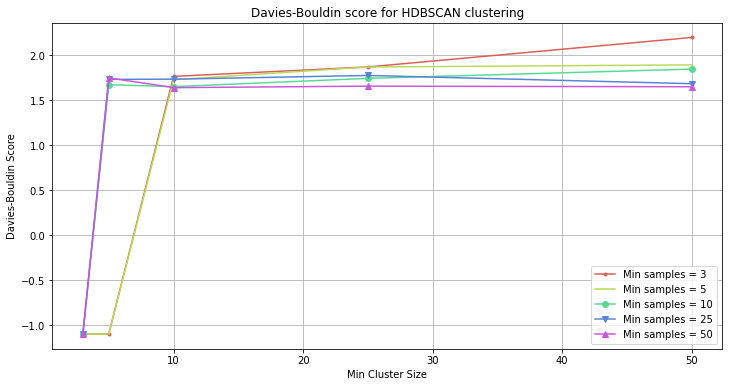

In [33]:
palette = sns.color_palette("hls", n_colors=len(min_samples_list))

# Closer to 0 is better
fig, ax1 = plt.subplots(figsize=(12, 6))
for idx, min_samples in enumerate(min_samples_list):
    ax1.plot(
        tuning_result_df["min_cluster_size"].loc[
            tuning_result_df["min_samples"] == min_samples
        ],
        tuning_result_df["davies_bouldin"].loc[
            tuning_result_df["min_samples"] == min_samples
        ],
        label="Min samples = "
        + str(min_samples), color=palette[idx],
        marker=marker_list[idx]
    )
ax1.set_xlabel("Min Cluster Size")
# ax1.set_xticks(min_cluster_size_list)
ax1.set_ylabel("Davies-Bouldin Score")
ax1.set_title("Davies-Bouldin score for HDBSCAN clustering")
ax1.legend(loc="best")
ax1.grid()

# Saving plot as image
fig.savefig(
    RESULT_DIR + "hdbscan/" + "skill_hdbscan_davies_bouldin_plot.png",
#     bbox_inches="tight",
#     dpi=150,
)

# Show plot
plt.show()

#### Relative validity

In [ ]:
# palette = sns.color_palette("hls", n_colors=len(min_cluster_size_list))

# # The higher the better
# plt.figure(figsize=(12, 6))
# for idx, min_cluster_size in enumerate(min_cluster_size_list):
#     plt.plot(
#         model_validation_df["min_samples"].loc[
#             model_validation_df["min_cluster_size"] == min_cluster_size
#         ],
#         model_validation_df["relative_validity"].loc[
#             model_validation_df["min_cluster_size"] == min_cluster_size
#         ],
#         label="Min cluster size = " + str(min_cluster_size),
#         color=palette[idx],
#         marker=marker_list[idx]
#     )
# plt.ylabel("Relative validity")
# plt.xlabel("Min samples")
# plt.title("Relative validity for HDBSCAN clustering")
# plt.legend(loc="best")
# plt.grid()

# # Saving plot as image
# fig.savefig(
#     RESULT_DIR + "hdbscan/" + "skill_hdbscan_relative-validity_plot.png",
# #     bbox_inches="tight",
# #     dpi=150,
# )

# # Show plot
# plt.show()

In [12]:
# Combine model sets
(
    model_list,
    label_list,
    outlier_list,
    exemplar_list,
    tuning_result,
) = pickle.load(open(RESULT_DIR + "hdbscan/" + "skill_hdbscan_model_tuning_list.pkl", "rb")
)

In [14]:
# best_index = np.argmax(model_validation['relative_validity'])
best_index = int(
    np.where(
        (np.array(tuning_result["min_samples"]) == 3)
        & (np.array(tuning_result["min_cluster_size"]) == 10)
    )[0]
)
print(best_index)
tuning_result_df = pd.DataFrame(tuning_result)

best_min_samples = tuning_result_df["min_samples"][best_index]
best_min_cluster_size = tuning_result_df["min_cluster_size"][best_index]
print(best_min_samples, best_min_cluster_size)
best_labels = label_list[best_index]
best_n_clusters = tuning_result_df["n_clusters"][best_index]
best_n_noises = tuning_result_df["n_noises"][best_index]
print(best_n_clusters, best_n_noises)

2
3 10
7736 32713


In [9]:
pca_datapoint = np.load(OUTPUT_DIR + "visualization/" + "skill_halfsize_pca_datapoints.npy")
umap_datapoint = np.load(OUTPUT_DIR + "visualization/" + "skill_halfsize_umap_datapoints.npy")
tsne_datapoint = np.load(OUTPUT_DIR + "visualization/" + "skill_halfsize_tsne_datapoints.npy")

Start PCA 2021-05-21 19:02:29.798446
End PCA 2021-05-21 19:02:29.832482
PCA duration 0:00:00.034036

Start t-SNE 2021-05-21 19:02:29.833470
End t-SNE 2021-05-21 19:02:29.862468
t-SNE duration 0:00:00.028998

Start UMAP 2021-05-21 19:02:29.862468
End UMAP 2021-05-21 19:02:29.890473
UMAP duration 0:00:00.028005



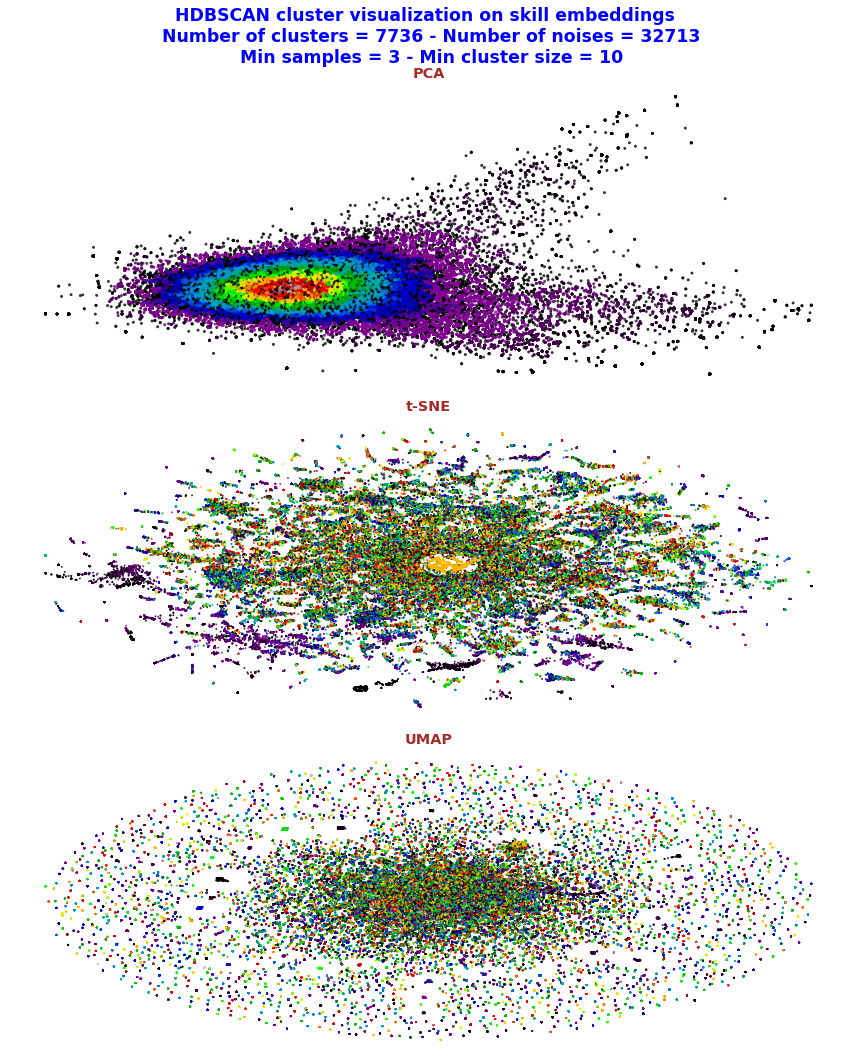

In [15]:
plot_title = (
    "HDBSCAN cluster visualization on skill embeddings \n Number of clusters = "
    + str(best_n_clusters) + " - Number of noises = " + str(best_n_noises)
    + "\n Min samples = "
    + str(best_min_samples)
    + " - Min cluster size = "
    + str(best_min_cluster_size)
)
plot_filename = (
    RESULT_DIR + "hdbscan/" + "skill_hdbscan_optimal-cluster-visualization.png"
)
palette = sns.color_palette("nipy_spectral", as_cmap=True)
# colors = cm.nipy_spectral(best_labels.astype(float) / best_k)
colors = best_labels

# Visualize clusters with PCA, UMAP, and t-SNE
visualize_cluster(
    plot_title,
    (12, 15),
    colors,
    palette,
    4,
    pca_datapoint,
    tsne_datapoint,
    umap_datapoint,
    pca=True,
    tsne=True,
    compute_umap=True,
    save_plots=True,
    plot_file=plot_filename,
)

## Display top words of each cluster

In [16]:
df_clusters = skill_docs.copy(deep=True)
df_clusters["model_type"] = "hdbscan"
df_clusters["skill_n_clusters"] = best_n_clusters
df_clusters['skill_cluster_label'] = best_labels
df_clusters

,row_id,key_id,job_id,skill_id,column_id,column_type,skill,skill_lemma,skill_token,model_type,skill_n_clusters,skill_cluster_label
0,10101,101,1,1,1,job_description,ameria investment consulting company,ameria investment consult company,"[ameria, investment, consult, company]",hdbscan,7736,7118
1,10201,102,1,2,1,job_description,requires high level,require high level,"[require, high, level]",hdbscan,7736,3406
2,10301,103,1,3,1,job_description,provides highly responsible,provide highly responsible,"[provide, highly, responsible]",hdbscan,7736,4973
3,10401,104,1,4,1,job_description,complex staff assistance,complex staff assistance,"[complex, staff, assistance]",hdbscan,7736,566
4,10501,105,1,5,1,job_description,chief financial officer,chief financial officer,"[chief, financial, officer]",hdbscan,7736,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
257200,190010103,1900101,19001,1,3,job_qualification,ra financial system,ra financial system,"[ra, financial, system]",hdbscan,7736,3960
257201,190010203,1900102,19001,2,3,job_qualification,higher legal education,high legal education,"[high, legal, education]",hdbscan,7736,4848
257202,190010303,1900103,19001,3,3,job_qualification,high pressure environment,high pressure environment,"[high, pressure, environment]",hdbscan,7736,1446
257203,190010403,1900104,19001,4,3,job_qualification,professional work experience,professional work experience,"[professional, work, experience]",hdbscan,7736,7135


In [17]:
wordcount = {}
sorted_wordcount = {}
for i in range(best_n_clusters):
    skills = df_clusters[df_clusters["skill_cluster_label"] == i]["skill"].values
    skills = " ".join(" ".join(skills).split())
    wordcount[i] = {}
    for j in skills.split():
        if j in wordcount[i]:
            wordcount[i][j] += 1
        else:
            wordcount[i][j] = 1
    sorted_wordcount[i] = sorted(wordcount[i].items(), key=lambda x: x[1], reverse=True)

In [ ]:
# tmp = df_clusters.copy(deep=True)
# tmp = tmp.loc[tmp['skill_cluster_label'] == 24]
# tmp.iloc[50:100, ]

In [18]:
topwords = {}
for key, i in sorted_wordcount.items():
    print("Cluster " + str(key) + ": ", end="")
    topwords[key] = ""
    n = 0
    for newkey, j in sorted_wordcount[key][:10]:
        print(newkey + "|", end="")
        topwords[key] = topwords[key] + newkey + "|"
        if n == 10:
            print("\n------------ ", end="")
        n += 1
    print()

Cluster 0: project|social|english|language|analysis|economic|including|development|good|programs|
Cluster 1: development|skills|unprovided|user|experience|develop|daily|administration|network|russian|
Cluster 2: skills|communication|computer|need|lot|supporting|implementation|sayat|nova|senior|
Cluster 3: developers|business|solid|project|management|practice|includes|production|primary|objective|
Cluster 4: responsible|ms|sql|database|developers|seeking|corporate|sales|manager|ccrm|
Cluster 5: software|skills|development|product|working|american|company|works|independent|judgment|
Cluster 6: skills|plan|team|start|sourcio|cjsc|sales|trade|relations|moral|
Cluster 7: development|skills|team|software|provide|work|technical|system|related|experience|
Cluster 8: skills|development|existing|systems|responsible|pr|activities|fulfill|excellent|communication|
Cluster 9: skills|university|degree|good|project|communication|global|fund|qualified|person|
Cluster 10: unprovided|team|individual|curr

In [19]:
topwords2 = {}
for key, i in sorted_wordcount.items():
    print("Cluster "+str(key)+": ", end='')
    topwords2[key] = ''
    for newkey, j in sorted_wordcount[key][10:20]:
        print(newkey + '|', end='')
        topwords2[key] = topwords2[key] + newkey + '|'
    print()

Cluster 0: urgently|seeks|vice|versa|successful|incumbent|seeking|experienced|candidates|web|
Cluster 1: languages|bank|restructuring|experts|expanding|company|based|financial|ensure|steady|
Cluster 2: system|administrator|updating|manage|division|daily|operations|data|entry|person|
Cluster 3: java|net|consulting|mixed|groups|consisting|position|timely|preparation|record|
Cluster 4: measures|aiming|significant|contribution|produce|branding|elements|effective|brand|management|
Cluster 5: newly|built|elite|house|project|coordinator|generoso|llc|java|developer|
Cluster 6: necessity|unit|goals|sms|drug|management|training|courses|updates|providing|
Cluster 7: excellent|russian|develop|support|strong|motivated|unprovided|language|codes|effective|
Cluster 8: childrens|daily|care|supervision|managing|cost|mobbis|llc|grant|making|
Cluster 9: studio|prepare|proposals|motivated|motivating|national|office|disaster|preparedness|plan|
Cluster 10: reports|investigative|bodies|chemonics|international

In [20]:
topwords3 = {}
for key, i in sorted_wordcount.items():
    print("Cluster "+str(key)+": ", end='')
    topwords3[key] = ''
    for newkey, j in sorted_wordcount[key][20:30]:
        print(newkey + '|', end='')
        topwords3[key] = topwords3[key] + newkey + '|'
    print()

Cluster 0: designer|new|laptop|computer|stakeholders|thorough|understanding|unix|systems|mentioned|
Cluster 1: growth|support|strategic|planning|public|funding|adviser|successful|candidate|automated|
Cluster 2: effective|child|protection|programme|encourage|active|participation|different|legal|issues|
Cluster 3: events|target|beneficiaries|needs|optimize|unit|operation|year|prior|work|
Cluster 4: conduct|language|pre|business|plan|targets|understand|requirements|maintain|labor|
Cluster 5: relations|strategy|aimed|virage|logic|general|population|sales|consultant|jermuk|
Cluster 6: superior|professional|institutional|measures|needed|deliver|better|service|marketing|activities|
Cluster 7: engineering|business|plan|web|retail|prepare|documents|capacity|initiatives|tax|
Cluster 8: authority|implementation|process|revenue|leakage|develop|new|products|compare|operations|
Cluster 9: everyday|routine|work|unit|testing|javascript|code|present|tax|information|
Cluster 10: life|skills|submit|finan

## Save cluster results to file

In [ ]:
df_clusters.to_csv(
    RESULT_DIR + "hdbscan/" + "skill_hdbscan_optimal-cluster-labels.csv", index=False
)

In [ ]:
# Save tuple of model sets
pickle.dump(
    (sorted_wordcount, topwords, topwords2, topwords3),
    open(RESULT_DIR + "hdbscan/" + "skill_hdbscan_optimal-topwords.pkl", "wb"),
)